# Get data

In [1]:
from awpy import Demo

# folder of demos
path = ".demos/"

# match one between Faze and Cloud 9 in the Perfect World Shanghai RMR for 4th place
# accessed via https://www.hltv.org/matches/2377025/match
match = "faze-vs-cloud-9-m1-mirage.dem"

# load demo
dem = Demo(path + match)

In [2]:
# other tables from demoparser that could be useful
for event_name, event in dem.events.items():
    print(f"{event_name}: {event.shape[0]} rows x {event.shape[1]} columns")

smokegrenade_expired: 113 rows x 40 columns
player_disconnect: 3 rows x 41 columns
cs_win_panel_match: 1 rows x 16 columns
buytime_ended: 19 rows x 16 columns
player_spawn: 190 rows x 36 columns
bomb_pickup: 58 rows x 36 columns
player_jump: 1256 rows x 36 columns
round_announce_last_round_half: 1 rows x 16 columns
cs_round_final_beep: 20 rows x 16 columns
bomb_defused: 3 rows x 38 columns
inferno_startburn: 80 rows x 40 columns
hegrenade_detonate: 52 rows x 40 columns
round_officially_ended: 36 rows x 16 columns
weapon_reload: 96 rows x 36 columns
hltv_versioninfo: 1 rows x 17 columns
announce_phase_end: 1 rows x 16 columns
hltv_fixed: 111 rows x 24 columns
begin_new_match: 1 rows x 16 columns
decoy_detonate: 2 rows x 40 columns
player_death: 140 rows x 95 columns
other_death: 85 rows x 47 columns
cs_round_start_beep: 57 rows x 16 columns
round_poststart: 19 rows x 16 columns
cs_pre_restart: 19 rows x 16 columns
bomb_begindefuse: 6 rows x 37 columns
inferno_expire: 80 rows x 40 column

# Rounds and Outcomes

* total number of rounds played
* win rate of each team (CT and T)
* Rounds where the bomb was planted but not defused

## total rounds

In [3]:
# one row per round so the number of rows is the number of rounds
dem.rounds.shape[0]

19

There were 19 rounds played

## win rate of each team

In [4]:
# labelling which team was CT and T in the first / second half

# obtaining the first team name and which side it was on and assigning values based on that
if list(dem.kills[['victim_team_name', 'victim_team_clan_name']].iloc[0, :])[0] == "CT":

    # first value is CT in this match
    first_half_CT = list(dem.kills[['victim_team_name', 'victim_team_clan_name']].iloc[0, :])[1]

    # assign T based on CT
    first_half_T = dem.kills.loc[dem.kills['victim_team_clan_name'] != first_half_CT]['victim_team_clan_name'].iloc[0,]

    # switch for second half
    second_half_CT, second_half_T = first_half_T, first_half_CT

else:
    # everything should just be flipped in the alternative case

    first_half_T = list(dem.kills[['victim_team_name', 'victim_team_clan_name']].iloc[0, :])[1]

    # assign T based on CT
    first_half_CT = dem.kills.loc[dem.kills['victim_team_clan_name'] != first_half_T]['victim_team_clan_name'].iloc[0,]

    # switch for second half
    second_half_CT, second_half_T = first_half_T, first_half_CT
    

print(f"CT 1st half: {first_half_CT}\n T 1st half: {first_half_T}\nCT 2nd half: {second_half_CT}\n T 2nd half: {second_half_T}")

CT 1st half: FaZe Clan
 T 1st half: Cloud 9
CT 2nd half: Cloud 9
 T 2nd half: FaZe Clan


In [5]:
import pandas as pd
import numpy as np

# assigning team name to round based on half and which in game team won
dem.rounds['winning_team'] = np.select(
    [
        (dem.rounds['round'].between(1, 12, inclusive='both')) & (dem.rounds['winner'] == "CT"), 
        (dem.rounds['round'].between(1, 12, inclusive='both')) & (dem.rounds['winner'] == "T"),
        (dem.rounds['round'].between(13, 24, inclusive='both')) & (dem.rounds['winner'] == "CT"),
        (dem.rounds['round'].between(13, 24, inclusive='both')) & (dem.rounds['winner'] == "T")
    ], 
    [
        first_half_CT, 
        first_half_T,
        second_half_CT,
        second_half_T
        
    ], 
    default='Unknown'
)

# labelling halves
dem.rounds['half'] = np.select(
    [
        (dem.rounds['round'].between(1, 12, inclusive='both')) , 
        (dem.rounds['round'].between(13, 24, inclusive='both')) ,
    ], 
    [
        "First", 
        "Second",
        
    ], 
    default='Overtime'
)


In [9]:
# counting number of round wins each team won per half
summary_series = dem.rounds.groupby(['winning_team', 'winner', 'half'])['round'].count()

# converting to table and sorting into coherent order
sum_table = pd.DataFrame(summary_series).sort_values(['winning_team', 'half'])


# finding win proportion per half
sum_table['proportion'] = np.select(
    [
        sum_table.index.get_level_values('half') == "First",
        sum_table.index.get_level_values('half') == "Second"
    ],
    [
        round(sum_table['round']/12, 4), # would ideal not like this not be hard coded
        round(sum_table['round']/7, 4)
    ],
    default='err'
)

sum_table

round proportion
winning_team winner half                    
Cloud 9      T      First       4     0.3333
             CT     Second      2     0.2857
FaZe Clan    CT     First       8     0.6667
             T      Second      5     0.7143

## Rounds where bomb was planted and not defused

In [10]:
# joining rounds with what the bomb did each round
rounds_bomb_table = dem.rounds.set_index('round').join(dem.bomb.set_index('round'))

# filtering to rounds where the bomb was actually planted
planted_not_defused_rounds = rounds_bomb_table[(rounds_bomb_table['event'] == 'planted')]

# filtering to rounds where bomb was not defused
planted_not_defused_rounds[planted_not_defused_rounds['reason'] != 'bomb_defused'][['winner', 'reason', 'winning_team', 'half', 'site', 'clock']]

,winner,reason,winning_team,half,site,clock
round,,,,,,
4,T,ct_killed,Cloud 9,First,BombsiteA,00:40
9,T,ct_killed,Cloud 9,First,BombsiteA,00:40
10,T,bomb_exploded,Cloud 9,First,BombsiteB,00:40
12,T,ct_killed,Cloud 9,First,BombsiteB,00:40
15,T,ct_killed,FaZe Clan,Second,BombsiteB,00:40
16,T,ct_killed,FaZe Clan,Second,BombsiteB,00:40
18,T,ct_killed,FaZe Clan,Second,BombsiteB,00:40


### Investigating round 10

Why did the bomb explode in round 10?

In [11]:
# number of kills in round 10
dem.kills[dem.kills['round'] == 10][['attacker_name', 'dmg_health', 'dmg_armor', 'attacker_team_name', 'victim_team_name', 'victim_name', 'victim_health', 'victim_armor_value', 'clock', 'ticks_since_bomb_plant']]

,attacker_name,dmg_health,dmg_armor,attacker_team_name,victim_team_name,victim_name,victim_health,victim_armor_value,clock,ticks_since_bomb_plant
66,Ax1Le,27,3,TERRORIST,CT,frozen,15,100,01:38,<NA>
67,rain,175,6,CT,TERRORIST,interz,100,87,00:51,<NA>
68,Ax1Le,27,3,TERRORIST,CT,broky,27,92,00:43,<NA>


Only 3 people were killed total in the round? 2 counter-terrorists and 1 terrorist

#### GIF of round 10

In [12]:
from awpy.plot import gif, PLOT_SETTINGS
from tqdm import tqdm
import os

if not os.path.isfile("de_mirage.gif"):
    frames = []

    for tick in tqdm(dem.ticks[dem.ticks["round"] == 10].tick.values[::128]):
        frame_df = dem.ticks[dem.ticks["tick"] == tick]
        frame_df = frame_df[
            ["X", "Y", "Z", "health", "armor_value", "pitch", "yaw", "team_name", "name"]
        ]

        points = []
        point_settings = []

        for _, row in frame_df.iterrows():
            points.append((row["X"], row["Y"], row["Z"]))

            # Determine team and corresponding settings
            team = "ct" if row["team_name"] == "CT" else "t"
            settings = PLOT_SETTINGS[team].copy()

            # Add additional settings
            settings.update(
                {
                    "hp": row["health"],
                    "armor": row["armor_value"],
                    "direction": (row["pitch"], row["yaw"]),
                    "label": row["name"],
                }
            )

            point_settings.append(settings)

        frames.append({"points": points, "point_settings": point_settings})

    print("Finished processing frames. Creating gif...")
    gif(f"{dem.header['map_name']}", frames, f"{dem.header['map_name']}.gif", duration=100)

Cloud9 (terrorists) got an early kill (Ax1Le -> frozen) in B-site and then fake rotated out. Faze over reacted and rotated to A and mid to control space. Faze was able to kill (rain -> interz) the lurking player outside of A-site and Cloud9 exploded into B-site. The player (broky) in B-site was not able to pick up any kills on Cloud9's entry and so the call seemingly was made to not retake.


Further questions:
* Were the CTs in a save round? It seems like Faze had some early aggression in Apts that did not play out for them?
* Did the CTs have defuse kits?
* How much health did the CTs have?

In [13]:
# filter to round 10, after the bomb was planted, alive players (non empty inventory), and CT players
ct_round_10_data = dem.ticks[(dem.ticks['round'] == 10) & (dem.ticks['is_bomb_planted'] == True) & (dem.ticks['inventory']) & (dem.ticks['team_name'] == "CT")]

In [14]:
# selection of relevant columns
ct_round_10_data.drop_duplicates(subset = "name", keep="first")[['name', 'inventory', 'health', 'armor_value', 'has_defuser', 'has_helmet', 'current_equip_value']]

,name,inventory,health,armor_value,has_defuser,has_helmet,current_equip_value
830962,rain,"[knife_butterfly, Desert Eagle, AK-47, Molotov]",68,96,True,True,5200
830966,ropz,"[knife_karambit, Five-SeveN]",100,100,False,False,1450
830968,karrigan,"[knife_karambit, USP-S, MP9]",75,84,False,False,2400


Very minimal equipment from the CTs: rain had a kit, helmet, but was hit for nearly 30 hp; ropz was at full health but had no helmet nor kit and only a pistol; karrigan had an smg, was already hit, had no kit nor helmet. 

Seems like a good call to not try to retake

In [15]:
# the CTs did not pick up any new weapons after the round ended
dem.events['item_pickup'][(dem.events['item_pickup']['round'] == 10) & (dem.events['item_pickup']['is_bomb_planted'] == True)]

,ct_team_clan_name,ct_team_name,defindex,game_phase,game_time,is_bomb_planted,is_ct_timeout,is_freeze_period,is_match_started,is_technical_timeout,...,user_last_place_name,user_name,user_ping,user_pitch,user_steamid,user_team_clan_name,user_team_name,user_yaw,user_zoom_lvl,round


State of economy beginning of round 10 and round 11

In [16]:
# grab first tick of rounds 10 and 11 to see how much money the CTs have
ct_economy_rounds_10_11 = dem.ticks[(dem.ticks['round'].isin([10, 11])) & (dem.ticks['team_name'] == "CT")].drop_duplicates(subset = ['name', 'round'], keep = 'first')[['name', 'inventory', 'round', 'current_equip_value', 'armor_value', 'has_helmet']]

ct_economy_rounds_10_11

,name,inventory,round,current_equip_value,armor_value,has_helmet
779190,broky,[knife_butterfly],10,1500,100,True
779192,rain,"[knife_butterfly, Desert Eagle, Smoke Grenade,...",10,2600,100,True
779196,ropz,"[knife_karambit, Smoke Grenade]",10,1450,100,False
779197,frozen,"[knife_stiletto, USP-S]",10,2100,100,False
779198,karrigan,"[knife_karambit, USP-S, Smoke Grenade]",10,2400,100,False
874480,broky,"[knife_butterfly, USP-S]",11,200,0,False
874482,rain,"[knife_butterfly, AK-47, Molotov]",11,4700,96,True
874486,ropz,"[knife_karambit, Flashbang]",11,1350,26,False
874487,frozen,"[knife_stiletto, Desert Eagle]",11,700,0,False
874488,karrigan,"[knife_karambit, USP-S]",11,2100,84,False


In [17]:
ct_economy_rounds_10_11.groupby('round')['current_equip_value'].sum()

round
10    10050
11     9050
Name: current_equip_value, dtype: uint32

Look up HLTV common monetary boundaries but fairly sure these are semi-buy to nearly eco rounds

# Round Durations

In [18]:
(60*1 + 55)

115

## What is the average duration of the rounds?

In [19]:
rounds = dem.rounds.copy()

# calculate total number of ticks
# end is when the round winner has been announced. After this there is an additional 7 seconds of gameplay
# freeze_end refers to when players are able to freely move around are not in the buy *only* phase
# evidence of this is found in rounds where the reason for round is 'time_ran_out' and the length of the round is 115 seconds
# round are 1:55 minutes in length which is 115 seconds
rounds['total_ticks'] = rounds['end'] - rounds['freeze_end']

# fairly sure matches are played on 64 tick servers so divide ticks by 64 to get seconds
rounds['seconds'] = round(rounds['total_ticks']/64, 2)

# quartile ranges for number of seconds
qs = list(rounds['seconds'].quantile(q = [0, .25, .5, .75, 1]))

# add average time
qs.append(rounds['seconds'].mean())

# create table 
seconds_five_num_summary = pd.DataFrame(
    qs
).T.rename(mapper = {0: "Min", 1: "1st quartile", 2: "Median", 3: "3rd quartile", 4: "Max", 5: "Average"}, axis = 1)

seconds_five_num_summary

,Min,1st quartile,Median,3rd quartile,Max,Average
0,31.0,76.0,87.44,115.0,135.5,93.389474


50% of rounds lasted a minute and a half or less. The average round lasted just over a minute and a half. Interestingly, pnly 25% of rounds lasted longer than the full length of the round

In [20]:
rounds.sort_values('seconds')

,round,start,freeze_end,end,official_end,winner,reason,bomb_plant,winning_team,half,total_ticks,seconds
16,17,136362,137642,139626,140074,T,ct_killed,<NA>,FaZe Clan,Second,1984,31.0
18,19,152480,156273,160290,160290,T,ct_killed,<NA>,FaZe Clan,Second,4017,62.77
15,16,130384,131664,135914,136362,T,ct_killed,135712,FaZe Clan,Second,4250,66.41
0,1,1016,2712,7392,7840,CT,bomb_defused,5150,FaZe Clan,First,4680,73.12
14,15,123931,125211,129936,130384,T,ct_killed,129852,FaZe Clan,Second,4725,73.83
12,13,108290,109986,114989,115437,CT,bomb_defused,113045,Cloud 9,Second,5003,78.17
8,9,67639,71090,76198,76646,T,ct_killed,74168,Cloud 9,First,5108,79.81
5,6,38801,42528,47703,48151,CT,t_killed,<NA>,FaZe Clan,First,5175,80.86
3,4,22506,23786,29265,29713,T,ct_killed,27115,Cloud 9,First,5479,85.61
2,3,15182,16462,22058,22506,CT,t_killed,<NA>,FaZe Clan,First,5596,87.44


## Which round was the shortest, and which was the longest?

In [21]:
# shortest round
rounds[rounds['seconds'] == rounds['seconds'].min()]

,round,start,freeze_end,end,official_end,winner,reason,bomb_plant,winning_team,half,total_ticks,seconds
16,17,136362,137642,139626,140074,T,ct_killed,<NA>,FaZe Clan,Second,1984,31.0


Round 17 was the shortest round

In [22]:
# longest round
rounds[rounds['seconds'] == rounds['seconds'].max()]

,round,start,freeze_end,end,official_end,winner,reason,bomb_plant,winning_team,half,total_ticks,seconds
7,8,57239,58519,67191,67639,CT,bomb_defused,65499,FaZe Clan,First,8672,135.5


Round 8 was the longest round

# Player Performance

In [23]:
# obtain player round team name information
player_info = dem.kills[['round', 'attacker_name', 'attacker_team_clan_name','attacker_team_name']].copy().drop_duplicates().set_index(['attacker_name', 'round'])


# index is just player name and only column is which team they are on
player_teams = player_info.reset_index().drop_duplicates('attacker_name').set_index('attacker_name')['attacker_team_clan_name'].sort_values()

player_teams = pd.DataFrame(player_teams).rename(columns = {'attacker_team_clan_name': 'team'})

## Who had the most kills in the match?

In [24]:
kills = dem.kills.copy()

# count the number of rows each player gets in each round
# fill in missing values with 0 kills
# pivot table to make 1 row per round player to allow for filtering based on number of kills
kills_per_round = kills.groupby(['round', 'attacker_name']).size().unstack().fillna(0).reset_index().melt(id_vars = "round", value_name = "kills")

player_kills = kills_per_round.groupby('attacker_name')['kills'].sum().reset_index().sort_values('kills', ascending=False).set_index('attacker_name')

player_kills.join(player_teams)

,kills,team
attacker_name,,
rain,21.0,FaZe Clan
HeavyGod,18.0,Cloud 9
ropz,18.0,FaZe Clan
Ax1Le,14.0,Cloud 9
frozen,14.0,FaZe Clan
karrigan,13.0,FaZe Clan
broky,11.0,FaZe Clan
Boombl4,10.0,Cloud 9
interz,9.0,Cloud 9


rain got the most kills

## How many players achieved multi-kills?

In [25]:
# number of multi-kills to look at
num_kills = 2

# sort and set index to allow joining for more context of players
multikill_round_players = kills_per_round.sort_values('round').set_index(['attacker_name', 'round'])

# join information about player context and filter to number of multi-kills
multikills = multikill_round_players.join(player_info)[multikill_round_players['kills'] >= num_kills].reset_index()

# show unique players overall
multikills.drop_duplicates(subset = "attacker_name").reset_index(drop = True)

,attacker_name,round,kills,attacker_team_clan_name,attacker_team_name
0,broky,1,2.0,FaZe Clan,CT
1,Boombl4,1,2.0,Cloud 9,TERRORIST
2,ropz,1,2.0,FaZe Clan,CT
3,rain,2,2.0,FaZe Clan,CT
4,karrigan,3,2.0,FaZe Clan,CT
5,Ax1Le,4,3.0,Cloud 9,TERRORIST
6,frozen,8,2.0,FaZe Clan,CT
7,ICY,8,2.0,Cloud 9,TERRORIST
8,interz,9,2.0,Cloud 9,TERRORIST
9,HeavyGod,13,2.0,Cloud 9,CT


Every player had at least 1 round where they got a multi-kll (CT or T)

In [26]:
# unique players by side
multikills.drop_duplicates(subset = ["attacker_name", 'attacker_team_name']).reset_index(drop = True).sort_values(['attacker_name', 'attacker_team_name'], ascending = [True, False])

,attacker_name,round,kills,attacker_team_clan_name,attacker_team_name
15,karrigan,19,2.0,FaZe Clan,TERRORIST
4,karrigan,3,2.0,FaZe Clan,CT
5,Ax1Le,4,3.0,Cloud 9,TERRORIST
1,Boombl4,1,2.0,Cloud 9,TERRORIST
9,HeavyGod,13,2.0,Cloud 9,CT
7,ICY,8,2.0,Cloud 9,TERRORIST
14,broky,17,2.0,FaZe Clan,TERRORIST
0,broky,1,2.0,FaZe Clan,CT
10,frozen,13,2.0,FaZe Clan,TERRORIST
6,frozen,8,2.0,FaZe Clan,CT


All FaZe members got a multi-kill on both halves. On Cloud 9: Ax1Le, Boombl4, and Icy did not get multi-kills on CT; HeavyGod did not get a multi-kill on T; and interz got a multi-kill on both halves.

#### Who got the most multi-kills?

In [27]:
# group by player name and count the number of rows (rounds with multi-kills) then sort by descending to find most
total_multikills = multikills.groupby(['attacker_name']).size().reset_index().rename(mapper = {0: "number_multi_kills"}, axis = 1).sort_values("number_multi_kills", ascending=False).set_index('attacker_name')

total_multikills.join(player_teams)

,number_multi_kills,team
attacker_name,,
rain,7,FaZe Clan
ropz,6,FaZe Clan
HeavyGod,4,Cloud 9
frozen,4,FaZe Clan
karrigan,3,FaZe Clan
Ax1Le,3,Cloud 9
Boombl4,2,Cloud 9
broky,2,FaZe Clan
interz,2,Cloud 9


rain got the most multi-kills

I wonder if getting a multi-kill in a round is a good indicator if you will win that round.

Conversely, how many rounds did a team *lose* after getting a mutli-kill in a round?

# Headshots

## What percentage of kills were headshots

In [28]:
# filter to just kills that were headshots
# count number of filtered rows over total number of kill rows 
round(kills[kills['headshot'] == True].shape[0]/kills.shape[0], 4)

0.5882

## Who had the highest headshot percentage

In [29]:
# same code as before now filtering to just kills that were headshots
# group by the round and player
# count number of rows (kills)
# fill the rest with 0
# pivot to make the kills column filterable
head_shot_kills = kills[kills['headshot'] == True].groupby(['round', 'attacker_name']).size().unstack().fillna(0).reset_index().melt(id_vars = "round", value_name = "headshot_kills")

# group by player and get the total number of (headshot) kills
player_kills_headshot = head_shot_kills.groupby('attacker_name')['headshot_kills'].sum().reset_index().sort_values('headshot_kills', ascending=False).set_index('attacker_name')

# join data with total number of kills
player_joined_kill_headshot = player_kills.join(player_kills_headshot)

# create percentage
player_joined_kill_headshot['percentage'] = player_joined_kill_headshot['headshot_kills']/player_joined_kill_headshot['kills']


player_joined_kill_headshot

,kills,headshot_kills,percentage
attacker_name,,,
rain,21.0,18.0,0.857143
HeavyGod,18.0,12.0,0.666667
ropz,18.0,13.0,0.722222
Ax1Le,14.0,8.0,0.571429
frozen,14.0,8.0,0.571429
karrigan,13.0,4.0,0.307692
broky,11.0,2.0,0.181818
Boombl4,10.0,7.0,0.700000
interz,9.0,5.0,0.555556


rain had the highest headshot percentage and highest number of headshot kills

# Weapon Analysis

In [30]:
# using item equip table to get grouping of weapons
weapon_id_table = dem.events['item_equip'][['item', 'weptype']].sort_values('weptype').drop_duplicates().rename(columns = {'item':'weapon'}).set_index('weapon')

# reidentify weapon type numbers to weapon type text
weapon_id_table['weptype'] = np.select(
    [
        weapon_id_table['weptype'] == 0,
        weapon_id_table['weptype'] == 1,
        weapon_id_table['weptype'] == 2,
        weapon_id_table['weptype'] == 3,
        weapon_id_table['weptype'] == 4,
        weapon_id_table['weptype'] == 5,
        weapon_id_table['weptype'] == 6,
        weapon_id_table['weptype'] == 7,
        weapon_id_table['weptype'] == 8,
        weapon_id_table['weptype'] == 9,
    ],
    [
        'knife',
        'pistol',
        'smg',
        'rifle',
        'unknown/not play in this match',
        'sniper',
        'unknown/not play in this match',
        'bomb',
        'unknown/not play in this match',
        'grenade'
    ],
    default='err'
)

weapon_id_table

,weptype
weapon,
knife,knife
hkp2000,pistol
glock,pistol
elite,pistol
deagle,pistol
p250,pistol
fiveseven,pistol
tec9,pistol
mp9,smg


## Which weapon was used the most across all rounds?

The simplest way to tackle this problem would be to examine what equipment players have the instant the buy time ends. However, that solution proved not to work as showcased by HeavyGod down below.

In [31]:
# select vars of interest
inventories = dem.ticks[['inventory', 'name', 'round', 'tick']].copy().reset_index(drop = True)

# get the inventories that are non-empty (player is alive) and has more than their knife
# it is unclear to me why many players are only indicated to only have their knife so many times
inventories_non_empty = inventories[(inventories['inventory'].apply(lambda x: len(x)  > 1))]

# group by each player in each round and randomly select one of their ticks and examine their weapons
# this probably isn't the best way to do as players can change equipment frequently in the duration of a round
# perhaps finding unique inventories by player by round would be better
# this method also only turns 188 rows (190 expected) and it's completely unclear why
# probably due to filtering out of near empty inventories but i find it difficult to believe that there are no time periods an individual player only has their knife for an extended duration of time (more than a tick)
# perhaps there are some data recording issues in this table
random_sample = inventories_non_empty.groupby(['round', 'name'], group_keys= False)[['inventory', 'name', 'round', 'tick']].apply(lambda x: x.sample(1))


# break apart the inventory as it is stored as a list and turn into a column to count the number of unique entries
pd.DataFrame(random_sample['inventory'].tolist()).drop(0, axis = 1).melt()['value'].value_counts()

value
Flashbang                 80
USP-S                     72
Smoke Grenade             72
Glock-18                  71
AK-47                     68
High Explosive Grenade    45
M4A1-S                    36
Molotov                   34
Desert Eagle              23
Incendiary Grenade        18
AWP                       15
C4                         5
M4A4                       3
Dual Berettas              3
P250                       3
MP9                        2
Five-SeveN                 2
Galil AR                   1
SSG 08                     1
Decoy Grenade              1
Name: count, dtype: int64

#### Why does HeavyGod only have a knife on record so far into the round?

Pieces of knowledge:
* Every tick is 1/64th of a second
    * Need to look 64*15 ticks from tick 2712
* However, tick 2712 is recorded as the *end* of the freeze time so this is the time by which he *should* have bought something
* There is a 15 second freeze time to the start of each round, where players can only buy/sell equipment
    * perhaps he dropped his glock in for a couple seconds in search of something else to buy?

In [32]:
inventories[(inventories['name'] == "HeavyGod") & (inventories['round'] == 1) & (inventories['inventory'].apply(lambda x: len(x) > 1))].head(1)

,inventory,name,round,tick
11299,"[knife_widowmaker, P250]",HeavyGod,1,3841


It wasn't until tick 3841 that HeavyGod is recorded have more than his knife in his inventory

In [33]:
num_ticks = 3841 - 2712
num_seconds = num_ticks/64
print(num_seconds)

17.640625


Okay, so that's only 17 seconds into the round but that's an extra 17 seconds *after* the dedicated buy phase, was he AFK?

Or perhaps round 1 is recorded differently as there is match warm up before it so it has different timings?
    
* Evidence that freeze_end - round_start for round 1 is 26.5 but for other rounds that value is precisely 20

In [34]:
(rounds['freeze_end'] - rounds['start'])/64

0          26.5
1          20.0
2          20.0
3          20.0
4          20.0
5     58.234375
6          20.0
7          20.0
8     53.921875
9          20.0
10         20.0
11         20.0
12         26.5
13         20.0
14         20.0
15         20.0
16         20.0
17     56.34375
18    59.265625
dtype: Float64

Interestingly, many are not quite 20 seconds. However, teams are allowed timeouts that occur during the beginning of a round while players are frozen, meaning that `freeze - start` start time will be longer. Additionally, we can see on round 12 that the time differential is 26.5 seconds; I'm unable to explan this, as I would expect round 13 to show this behavior (as teams switch sides) not round 12.

#### But HeavyGod's teammates had other equipment prior to 17.64 seconds into the round, right?

In [35]:
temp = inventories[(inventories['round'] == 1) & (inventories['inventory'].apply(lambda x: len(x) >= 1))].set_index('name').join(player_teams)

temp[temp['team'] == "Cloud 9"].head(10)

,inventory,round,tick,team
name,,,,
Ax1Le,"[bayonet, Glock-18]",1,2712,Cloud 9
interz,"[knife_karambit, Glock-18]",1,2712,Cloud 9
Boombl4,"[knife_butterfly, Smoke Grenade, Flashbang, Gl...",1,2712,Cloud 9
ICY,"[knife_karambit, Glock-18]",1,2712,Cloud 9
HeavyGod,[knife_widowmaker],1,2712,Cloud 9
Ax1Le,"[bayonet, Glock-18]",1,2713,Cloud 9
interz,"[knife_karambit, Glock-18]",1,2713,Cloud 9
Boombl4,"[knife_butterfly, Smoke Grenade, Flashbang, Gl...",1,2713,Cloud 9
ICY,"[knife_karambit, Glock-18]",1,2713,Cloud 9


So, Boombl4 had a couple pieces of utility and everyone else had their normal pistol. Did HeavyGod drop his pistol on accident and then go AFK for 17 seconds? Let's watch the round back

In [36]:
from awpy.plot import gif, PLOT_SETTINGS
from tqdm import tqdm
import os

map_name = dem.header['map_name']
round = 1


if not os.path.isfile(f"{map_name}_round_{round}.gif"):
    frames = []

    for tick in tqdm(dem.ticks[dem.ticks["round"] == round].tick.values[::128]):
        frame_df = dem.ticks[dem.ticks["tick"] == tick]
        frame_df = frame_df[
            ["X", "Y", "Z", "health", "armor_value", "pitch", "yaw", "team_name", "name"]
        ]

        points = []
        point_settings = []

        for _, row in frame_df.iterrows():
            points.append((row["X"], row["Y"], row["Z"]))

            # Determine team and corresponding settings
            team = "ct" if row["team_name"] == "CT" else "t"
            settings = PLOT_SETTINGS[team].copy()

            # Add additional settings
            settings.update(
                {
                    "hp": row["health"],
                    "armor": row["armor_value"],
                    "direction": (row["pitch"], row["yaw"]),
                    "label": row["name"],
                }
            )

            point_settings.append(settings)

        frames.append({"points": points, "point_settings": point_settings})

    print("Finished processing frames. Creating gif...")
    gif(f"{map_name}", frames, f"{map_name}_round_{round}.gif", duration=100)

Hmmm, the gif was not very helpful. Let's watch the VOD back of round 1 on mirage.


Nope, he definitely has a gun. I cannot explain this any further besides a data recording issue.


The issue is noted and next time inventories need to be used for analysis, caution will be taken

## What are the kill counts for each type of weapon (rifle, SMG, pistols, etc)?

In [37]:
def kills_grouping(grouping_types = ['weapon']):
    return pd.DataFrame(dem.kills.groupby(grouping_types).size()).rename(mapper = {0: 'kills'}, axis = 1).sort_values('kills', ascending=False)


In [38]:
kills_grouping(['weapon'])

,kills
weapon,
ak47,57
m4a1_silencer,26
usp_silencer,10
awp,9
deagle,9
glock,5
mp9,4
famas,3
galilar,3


### Player kills by weapon

In [39]:
kills_grouping(['attacker_name', 'weapon'])[kills_grouping(['attacker_name', 'weapon'])['kills'] > 2]

kills
attacker_name weapon              
rain          ak47              11
Ax1Le         ak47              10
 karrigan     ak47               8
frozen        ak47               8
ropz          m4a1_silencer      7
              ak47               6
HeavyGod      m4a1_silencer      5
broky         awp                5
Boombl4       ak47               4
 karrigan     m4a1_silencer      4
HeavyGod      ak47               4
ICY           awp                4
rain          m4a1_silencer      3
HeavyGod      deagle             3
rain          deagle             3
interz        ak47               3

# Clutching 1vX situations

In [40]:
round_winner = rounds[['round', 'winner', 'reason']].set_index('round')

In [41]:
# detect rounds where 1 player is left alive on each team
# find rounds were 4 teammates died
deaths_per_round = kills_grouping(['round', 'victim_team_name']).sort_index().reset_index().set_index('round').rename(columns = {'victim_team_name':'team', 'kills':'deaths'})

# find winner of that round and confirm that the respective team won that round
clutch_rounds = deaths_per_round[deaths_per_round['deaths'] == 4].join(round_winner).reset_index()

clutch_rounds

,round,team,deaths,winner,reason
0,1,CT,4,CT,bomb_defused
1,4,TERRORIST,4,T,ct_killed
2,7,CT,4,CT,time_ran_out
3,18,TERRORIST,4,T,ct_killed


# Grenade Usage

## How many grenades (smokes, flashes, HE, molotovs) were thrown in the match?


In [51]:
grenades = dem.grenades.copy()

unique_grenades = grenades.drop_duplicates(subset = ['thrower', 'grenade_type', 'round'])

unique_grenades = unique_grenades[~unique_grenades['ticks_since_round_start'].isna()]

grenades_table = pd.DataFrame(unique_grenades.groupby('grenade_type').size()).rename(columns = {0: 'number'}).sort_values('number', ascending = False)

grenades_table

,number
grenade_type,
smoke,107
flashbang,83
he_grenade,50
molotov,41
incendiary_grenade,38
decoy,2


### By player?

In [52]:
player_grenades_total = pd.DataFrame(unique_grenades.groupby(['thrower']).size()).rename(columns = {0: 'number'}).sort_values('number', ascending = False)

player_grenades_total.head(5).join(player_teams)

,number,team
thrower,,
karrigan,47,FaZe Clan
rain,43,FaZe Clan
ropz,41,FaZe Clan
Boombl4,35,Cloud 9
frozen,35,FaZe Clan


Wow. Of the top 5 people who threw grenades, four of them were from FaZe clan. I wonder if number 6 is FaZe as well?

In [53]:
player_grenades_total.head(6).join(player_teams)

,number,team
thrower,,
karrigan,47,FaZe Clan
rain,43,FaZe Clan
ropz,41,FaZe Clan
Boombl4,35,Cloud 9
frozen,35,FaZe Clan
broky,33,FaZe Clan


Indeed it is. I wonder if that also contributed to FaZe winning this match.

By player and grenade type

In [56]:
player_grenades_type = pd.DataFrame(unique_grenades.groupby(['thrower', 'grenade_type']).size()).rename(columns = {0: 'number'}).sort_values('number', ascending = False)

player_grenades_type.head(5)

,,number
thrower,grenade_type,
Boombl4,smoke,14
ropz,smoke,13
rain,smoke,13
Boombl4,flashbang,12
karrigan,flashbang,12


### How many more grenades did FaZe throw compared to Cloud 9?

In [86]:
grenades_player_index = unique_grenades.set_index('thrower')
grenade_teams = grenades_player_index.join(player_teams).reset_index()

pd.DataFrame(grenade_teams.groupby('team').size()).rename(columns = {0: "thrown"}).sort_values("thrown", ascending=False)

,thrown
team,
FaZe Clan,199
Cloud 9,121


FaZe threw 78 grenades more than Cloud 9

## Identify rounds with the highest grenade usage

In [63]:
unique_grenades.groupby('round').size().sort_values(ascending=False).head()

round
4     31
12    29
8     24
6     23
19    19
dtype: int64

Round four had 31 grenades thrown? No way.

In [71]:
unique_grenades[unique_grenades['round'] == 4].shape

(31, 13)

Huh I guess it did. Wow.

Who threw the most grenades?

In [90]:
grenade_teams[grenade_teams['round'] == 4].groupby(['team', 'grenade_type']).size()

team       grenade_type      
Cloud 9    flashbang             4
           molotov               5
           smoke                 4
FaZe Clan  flashbang             5
           he_grenade            4
           incendiary_grenade    4
           smoke                 5
dtype: int64

# Bomb Events

## How many times was the bomb planted?

In [105]:
dem.events['bomb_planted'].shape[0]

10

## Which players planted the bomb most often?

In [117]:
dem.events['bomb_planted'].groupby('user_name').size().rename("bomb_plants").sort_values(ascending=False).to_frame().join(player_teams)

,bomb_plants,team
user_name,,
Boombl4,4,Cloud 9
broky,4,FaZe Clan
ICY,2,Cloud 9


### Did bomb plants lead to that team winning the round

In [145]:
bomb_winnings = dem.events['bomb_planted'].set_index('round').join(round_winner).reset_index()

bomb_winnings[bomb_winnings['winner'] == "T"].groupby(['user_team_clan_name', 'reason']).size().rename('round_wins').to_frame()

round_wins
user_team_clan_name reason                   
Cloud 9             bomb_exploded           1
                    ct_killed               3
FaZe Clan           ct_killed               3

Cloud 9 won with the bomb planted once because CTs did not attempt a re-take and so the bomb was left to explode. Whereas in every other round, the CTs attempted to a re-take and were unsucessful

# Spatial Analysis


## Heatmaps

### Where did most kills occur on the map?

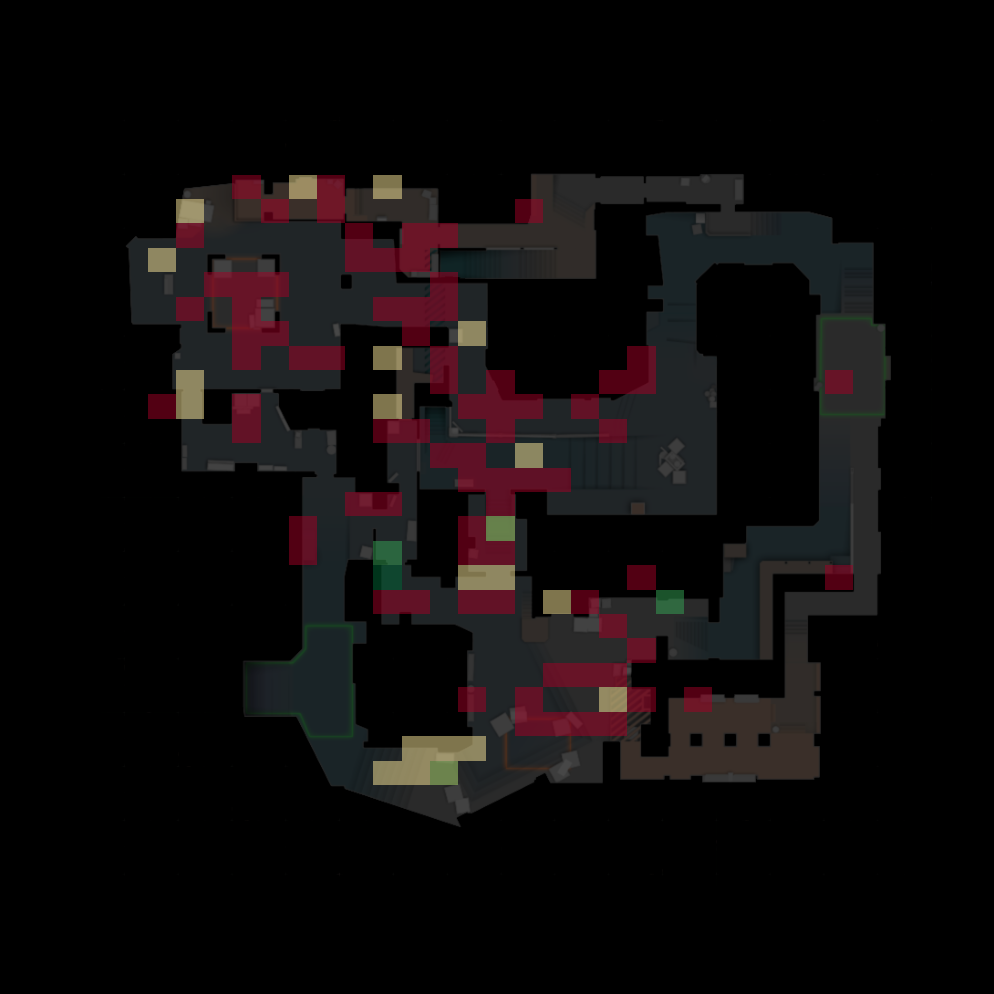

In [173]:
from awpy.plot import heatmap



player_locations = list(
    dem.kills[["attacker_X", "attacker_Y", "attacker_Z"]].itertuples(index=False, name=None)
)
fig, ax = heatmap(
    map_name=dem.header['map_name'],
    points=player_locations,
    method="hist",
    size=25,
    vary_alpha=False,
)

### Which bomb site was planted on the most?

In [204]:
bomb = dem.bomb.copy()

bomb['terrorist_team'] = np.select(
    [
        dem.bomb['round'] <= 12
    ],
    [
        first_half_T,
    ],
    default=second_half_T
)


In [208]:
bomb[bomb['event'] == "planted"].groupby(['terrorist_team', 'site']).size().rename("times_planted").to_frame()

times_planted
terrorist_team site                    
Cloud 9        BombsiteA              4
               BombsiteB              2
FaZe Clan      BombsiteB              4

## Movement

I'm not so sure what the best way to analyze movement is right now. Euclidean distance makes very little sense there are obstructions in the paths of players. Manhattan could make sense but the route between two locations is not always symmetric. I have read about the use of nav meshes but I am not sure how to implement them in Python.

### Who traveled the most distance in the game?

In [213]:
dem.ticks[['X', 'Y', 'Z', 'name']]

,X,Y,Z,name
27120,-1720.000000,-1896.000000,-267.602295,broky
27121,1216.000000,-307.000000,-164.814819,Ax1Le
27122,-1656.000000,-1976.000000,-267.458313,rain
27123,1136.000000,32.000000,-164.788452,interz
27124,1216.000000,-115.000000,-163.968750,Boombl4
...,...,...,...,...
1602775,-801.978516,-912.848938,-167.968750,ICY
1602776,32.054688,-2188.030029,-39.968750,ropz
1602777,-291.991516,-2196.822266,-170.828491,frozen
1602778,-821.933472,-2329.110596,-173.347412,karrigan


### Which player had the fastest average movement speed?

# Economic Analysis

## What was the average starting money for each team per round?

In [260]:
starting_moments = dem.ticks[dem.ticks['tick'].isin(rounds['freeze_end'])][['current_equip_value', 'name', 'team_clan_name', 'round']].reset_index(drop = True)

starting_moments.groupby('team_clan_name')['current_equip_value'].mean().reset_index()

,team_clan_name,current_equip_value
0,Cloud 9,3378.421053
1,FaZe Clan,4291.578947


### Is this difference actually real?

Hypothesis test that FaZe on average started each round with a greater amount of equipment value

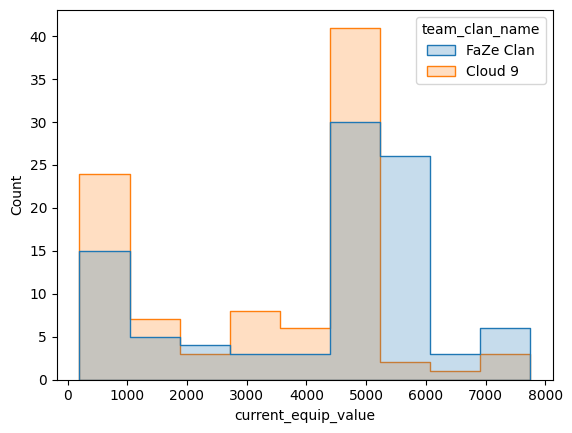

In [267]:
import matplotlib.pyplot as plt
import seaborn as sns 

sns.histplot(x = 'current_equip_value', hue = 'team_clan_name', data = starting_moments, element="step")
plt.show()

Certainly not normal looking data. Rather bi-modal with peaks around 1000 dollars and 5000 dollars. 

Will need to look at medians

In [277]:
starting_moments.groupby('team_clan_name')['current_equip_value'].median().reset_index()

,team_clan_name,current_equip_value
0,Cloud 9,4200.0
1,FaZe Clan,5050.0


Probably different

In [273]:
from scipy.stats import ranksums

cloud9_equip = starting_moments[starting_moments['team_clan_name'] == "Cloud 9"]['current_equip_value']
faze_equip = starting_moments[starting_moments['team_clan_name'] == "FaZe Clan"]['current_equip_value']

ranksums(cloud9_equip, faze_equip, alternative="less")

RanksumsResult(statistic=-4.177999674594247, pvalue=1.4704203796953065e-05)

Overwhelming evidence to conclude that on average FaZe started rounds with a higher equipment value.

## Identify rounds where a team won despite having an economic disadvantage.

In [386]:
economy_starting_sums = starting_moments.groupby(['round', 'team_clan_name'])['current_equip_value'].sum().to_frame().reset_index()

economy_starting_sums = economy_starting_sums.pivot(index = "round", columns = 'team_clan_name', values = 'current_equip_value').reset_index()

c9 = economy_starting_sums['Cloud 9'].reset_index(drop = True)
fz = economy_starting_sums['FaZe Clan'].reset_index(drop = True)

c9 = pd.to_numeric(c9.astype(str).str.strip(), errors='coerce')
fz = pd.to_numeric(fz.astype(str).str.strip(), errors='coerce')

economy_starting_sums['difference'] = c9 - fz

economy_starting_sums = economy_starting_sums.set_index('round')

economy_context = economy_starting_sums.join(rounds.set_index('round')['winning_team'])

In [ ]:
# rounds where FaZe had more money but the winning team was Cloud 9
economy_context[(economy_context['difference'] <= 0) & (economy_context['winning_team'] == "Cloud 9")]

,Cloud 9,FaZe Clan,difference,winning_team
round,,,,
4,25000,30450,-5450,Cloud 9
9,22500,29100,-6600,Cloud 9
12,26850,30750,-3900,Cloud 9


There were three rounds where Cloud 9 was at the economic disadvantage but still able to win the round.

In [392]:
# rounds where Cloud 9 had more money but FaZe won the round
economy_context[(economy_context['difference'] >= 0) & (economy_context['winning_team'] == "FaZe Clan")]

,Cloud 9,FaZe Clan,difference,winning_team
round,,,,
11,27250,9050,18200,FaZe Clan
15,24900,23400,1500,FaZe Clan


There were only two rounds where FaZe had the economic disadvantage and still won the round.

# Damage Statistics

## Who dealt the most total damage across all rounds?

In [417]:
damages = dem.damages

# Remove team damage
damages = damages[damages["attacker_team_name"] != damages["victim_team_name"]]

# Remove self damage
damages = damages[~damages["attacker_name"].isna()]

total_damage = damages.groupby('attacker_name')['dmg_health_real'].sum().reset_index().sort_values('dmg_health_real', ascending = False).set_index('attacker_name')

total_damage['adr'] = total_damage['dmg_health_real']/rounds.shape[0]

total_damage.join(player_teams)

,dmg_health_real,adr,team
attacker_name,,,
ropz,2036,107.157895,FaZe Clan
rain,2016,106.105263,FaZe Clan
HeavyGod,1938,102.000000,Cloud 9
Ax1Le,1632,85.894737,Cloud 9
karrigan,1470,77.368421,FaZe Clan
frozen,1399,73.631579,FaZe Clan
Boombl4,1217,64.052632,Cloud 9
broky,1196,62.947368,FaZe Clan
ICY,1053,55.421053,Cloud 9


## How does the average damage dealt compare between players on each team?

In [437]:
damage_team_overall = damages.groupby(['attacker_team_clan_name'])['dmg_health_real'].agg(['min', 'mean', 'median', 'max', 'sum'])

damage_team_overall

,min,mean,median,max,sum
attacker_team_clan_name,,,,,
Cloud 9,0,32.264423,25.0,100,6711
FaZe Clan,0,32.083004,25.0,100,8117


In [442]:
damage_team_player = damages.groupby(['attacker_team_clan_name', 'attacker_name'])['dmg_health_real'].agg(['min', 'mean', 'median', 'max', 'sum']).reset_index('attacker_name')

damage_team_player

,attacker_name,min,mean,median,max,sum
attacker_team_clan_name,,,,,,
Cloud 9,Ax1Le,3,29.142857,25.5,100,1632
Cloud 9,Boombl4,1,29.682927,26.0,100,1217
Cloud 9,HeavyGod,0,35.236364,26.0,100,1938
Cloud 9,ICY,1,30.970588,18.0,100,1053
Cloud 9,interz,0,39.590909,24.5,100,871
FaZe Clan,karrigan,1,30.625000,27.0,100,1470
FaZe Clan,broky,0,35.176471,22.0,100,1196
FaZe Clan,frozen,1,24.120690,13.5,100,1399
FaZe Clan,rain,0,40.320000,27.5,100,2016


In [455]:
damage_team_context = damage_team_player.join(damage_team_overall['sum'], rsuffix="_overall_team")

damage_team_context['proportion'] = damage_team_context['sum'] / damage_team_context['sum_overall_team']

damage_team_context.sort_values('proportion', ascending=False)

,attacker_name,min,mean,median,max,sum,sum_overall_team,proportion
attacker_team_clan_name,,,,,,,,
Cloud 9,HeavyGod,0,35.236364,26.0,100,1938,6711,0.288780
FaZe Clan,ropz,2,32.317460,25.0,100,2036,8117,0.250832
FaZe Clan,rain,0,40.320000,27.5,100,2016,8117,0.248368
Cloud 9,Ax1Le,3,29.142857,25.5,100,1632,6711,0.243183
Cloud 9,Boombl4,1,29.682927,26.0,100,1217,6711,0.181344
FaZe Clan,karrigan,1,30.625000,27.0,100,1470,8117,0.181101
FaZe Clan,frozen,1,24.120690,13.5,100,1399,8117,0.172354
Cloud 9,ICY,1,30.970588,18.0,100,1053,6711,0.156907
FaZe Clan,broky,0,35.176471,22.0,100,1196,8117,0.147345
